# Exercise 5b: Machine learning on graphs

## Introduction

There are a variety of machine learning tasks that we can perform on a graph.  One common use case would be code classification (is this node a fraudster or not?).  We can also do link prediction (should I recommend this item to a user?) or graph prediction (which molecule is this?), which are beyond the scope of this course.

For this exercise, we will be using our NLP-based graph.  (We will recreate it below if you no longer have access to that database.)  We are going to try to do some node classification based on node embeddings, which will will create with [GDS](https://neo4j.com/docs/graph-data-science/current/algorithms/node-embeddings/).  Those embeddings will then be used in a simple ML pipeline created with `scikit-learn`.

In [4]:
%matplotlib inline

import json
import re
import urllib
from pprint import pprint
import time
from tqdm import tqdm

from py2neo import Node, Graph, Relationship, NodeMatcher
from py2neo.bulk import merge_nodes

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [24]:
uri = ''
user = 'neo4j'
pwd = ''

graph = Graph(uri, auth=(user, pwd))
nodes_matcher = NodeMatcher(graph)

## Run this cell if you need to repopulate the graph

In [ ]:
query1 = """CALL apoc.import.json('https://raw.githubusercontent.com/cj2001/nodes2021_kg_workshop/main/json_files/svo.json')"""

query2 = """MATCH (n:Node) 
            CALL apoc.create.addLabels(n, n.node_labels) 
            YIELD node 
            RETURN COUNT(*)
"""

query3 = """MATCH (n:Node) 
            WITH n.name AS name, COLLECT(n) AS nodes 
            WHERE SIZE(nodes)>1 
            FOREACH (el in nodes | DETACH DELETE el)
"""

graph.run(query1)
graph.run(query2)
graph.run(query3)

## Just for fun (and slightly off topic): a tiny bit of entity resolution / disambiguation

Let's just see what happens when we look at the overlap between two possible duplicate nodes for Barack Obama.  We could hypothesize that there would be overlap in the nodes each are connected to.  Let's see...  

In [44]:
pbo_ls = []
pbo = graph.run('MATCH (n:Node {name: "president barack obama"})--(m) RETURN DISTINCT m.name')
for record in pbo:
    pbo_ls.append(record[0])
print('Total number of connected nodes: ', len(pbo_ls))
pbo_ls

Total number of connected nodes:  1


['affordable care act']

In [45]:
obm_ls = []
obm = graph.run('MATCH (n:Node {name: "oh bah mə"})--(m) RETURN DISTINCT m.name')
for record in obm:
    obm_ls.append(record[0])
print('Total number of connected nodes: ', len(obm_ls))

Total number of connected nodes:  115


In [46]:
pbo_set = set(pbo_ls)
obm_set = set(obm_ls)
if (pbo_set & obm_set):
    print('Number of overlapping elements: ', len(pbo_set & obm_set))
    print('Percent of overlapping elements: ', len(pbo_set & obm_set)/len(pbo_ls))
    print(pbo_set & obm_set)

Number of overlapping elements:  1
Percent of overlapping elements:  1.0
{'affordable care act'}


## Observation

If we choose the starting node to be `president barack obama`, then we see that there is 100% overlap with `oh bah mə`.

## _EXERCISE:_ What if we reverse the order of those two?

So what happens if we are comparing `oh bah mə` to `president barack obama`?  (You can probably figure this out without having to run code.)  We will look at another example below once we create node embeddings.

## Creating some labels

Classification, being a supervised problem, requires node labels.  We have some of those already!  

Let's say we wanted to determine if a given node was a person, place, or thing (abbreviated below as `pptu`, where the `u` stands for unknown).  We can use our node labels to create a toy problem for us.  

I have manually created a list of node labels below and then set a propert on each node that will correspond to the label for the classification model.  These are completely arbitrary and just for demonstration purposes.

In [29]:
query_person = """MATCH (n) WHERE ANY (x in n.node_labels WHERE x IN 
                   ['Person', 'Organization', 'EducationalOrganization', 'Corporation', 
                    'SportsTeam', 'SportsOrganization', 'GovernmentOrganization']) 
               SET n.pptu_person = 1;
"""
           
query_place = """MATCH (n)
                   WHERE ANY (x in n.node_labels WHERE x IN 
                       ['Place', 'AdministrativeArea', 'Country', 'Museum', 
                        'TouristAttraction', 'CivicStructure', 'City', 'CollegeOrUniversity',
                        'MovieTheater', 'Continent', 'MusicVenue', 'LandmarksOrHistoricalBuildings', 
                        'Cemetery', 'BodyOfWater', 'PlaceOfWorship', 'Restaurant', 
                        'LakeBodyOfWater'])
                SET n.pptu_place = 1;
"""
           
query_thing = """MATCH (n)
                   WHERE ANY (x in n.node_labels WHERE x IN 
                       ['Thing', 'Periodical', 'Book', 'Movie', 
                        'Event', 'MusicComposition', 'SoftwareApplication', 'ProductMode', 
                        'DefenceEstablishment', 'MusicRecording', 'LocalBusiness', 'CreativeWork', 
                        'Article', 'TVEpisode', 'ItemList', 'TVSeries', 
                        'Airline', 'Product', 'VisualArtwork', 'VideoGame', 
                        'Brand'])
                SET n.pptu_thing = 1;
"""
           
query_unk = """MATCH (n)
               WHERE n.pptu_person IS NULL
                   AND n.pptu_place IS NULL
                   AND n.pptu_thing IS NULL
               SET n.pptu_unknown = 1;
"""

graph.run(query_person)
graph.run(query_place)
graph.run(query_thing)
graph.run(query_unk)

(No data)

## Creating the in-memory graph

As before, we need to create an in-memory graph through GDS, which will be used to calculate our node embeddings in subsequent steps.  In this case, as seen below, we are actually looking at _all_ nodes and _all_ relationships in the graph.  This is, in general, bad practice, especially as the graph size grows.  

You should note that most of the GDS algorithms require monopartite, undirected graphs.  Our graph is not actually undirected, but we will treat it that way for the purposes of this demonstration.  When we do that, GDS essentially mimics two relationships between nodes: incoming and outgoing.  So you should see double the number of your total amount of relationships when you create this in-memory graph.

In [30]:
query = """CALL gds.graph.create(
               'all_nodes',
               {
                    AllNodes: {label: 'Node', 
                               properties: 
                                   {word_vec_embedding: {property: 'word_vec'}}}
               },
               {
                    AllRels: {type: '*', orientation: 'UNDIRECTED'}
               }
           )
           YIELD graphName, nodeCount, relationshipCount
"""

graph.run(query)

graphName,nodeCount,relationshipCount
all_nodes,657,1116


## node2vec

We will now create some embeddings with `node2vec`.  If you recall from earlier in this workshop, `node2vec` is similar to `word2vec`, in that it uses a skip-gram approach.  What this means for us is that there will be a random walk of a certain length for each node around the graph and that will be used to create the embeddings.  

#### _THOUGHT EXERCISE:_ What do you suppose will happen to nodes that are either not connected or only have a relationship or two and not connected to the bulk of the other nodes???

So let's create a 10-dimensional node embedding for every node and see what they look like.

In [33]:
query = """CALL gds.beta.node2vec.stream('all_nodes', {embeddingDimension: 10}) 
           YIELD nodeId, embedding 
           RETURN gds.util.asNode(nodeId).name as name, embedding
           LIMIT 5
"""

graph.run(query)

name,embedding
oh bah mə,"[-0.24720695614814758, -0.6863935589790344, -0.41461920738220215, -0.3094315230846405, 0.5807867050170898, -0.3993242084980011, 0.35283851623535156, 0.015967505052685738, 0.34295031428337097, 0.6766219735145569]"
american politician,"[-0.6272075772285461, -0.45485708117485046, -0.39356353878974915, -0.5020443797111511, 0.7245380282402039, -1.120749592781067, -0.30806630849838257, 0.25718218088150024, 0.031936533749103546, 0.7853379249572754]"
44th president,"[0.9916790723800659, -0.48404741287231445, 0.3773007392883301, -1.0749491453170776, 0.7011966705322266, -0.09479381144046783, 0.026304025202989578, 0.1164717748761177, -0.11911585927009583, 0.09826155006885529]"


## Writing these vectors to the graph

In [48]:
query = """CALL gds.beta.node2vec.write('all_nodes', 
               { 
                   embeddingDimension: 10, 
                   writeProperty: 'n2v_all_nodes'
               } 
           )
"""

graph.run(query)

nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
657,657,0,3596,187,"{negativeSamplingExponent: 0.75, initialLearningRate: 0.025, writeConcurrency: 4, negativeSamplingRate: 5, walksPerNode: 10, positiveSamplingFactor: 0.001, relationshipWeightProperty: null, iterations: 1, returnFactor: 1.0, concurrency: 4, walkLength: 80, windowSize: 10, writeProperty: 'n2v_all_nodes', inOutFactor: 1.0, embeddingDimension: 10, nodeLabels: ['*'], sudo: false, minLearningRate: 0.0001, relationshipTypes: ['*'], walkBufferSize: 1000, username: null}"


## Another entity resolution approach

We now have vectors.  We can measure the distance between two vectors and use that to infer similarity.  There are many ways to do that, but let's just try the classic [cosine similarity](https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/cosine/).

#### For fun

Try some other nodes compared to `oh bah mə`.  `mitch mcconnell` is a good one.  Can you explain that result?

In [53]:
query = """MATCH (n1:Node {name: 'oh bah mə'}) 
           MATCH (n2:Node {name: 'hillary clinton'}) 
           RETURN gds.alpha.similarity.cosine(n1.n2v_all_nodes, n2.n2v_all_nodes) AS similarity
"""

graph.run(query)

similarity
0.8774377248988636


## Getting started with ode classification

Let's now actually do the node classification.  Pulling down our data, you will notice that each node could have multiple classification: a multiclass problem.  For the sake of demonstration (and for the significant lack of data in this small graph), we are just going to do some binary classification, to try and predict person versus not-person, place versus not-place, etc.  

Also, if you were to query the data, you would see that we have a significant class imbalance.  We will be using a support vector machine for this model and the one built into `scikit-learn` (`svm.SVC`) has some ability to handle that.  In reality, for a proper dataset we would do some sampling work to try and even out the class imbalance a bit.  However, for this very small dataset, we are going to just use what we have.  In a real problem, you would be spending some significant time on that problem.

In [54]:
query = """MATCH (n:Node) 
           RETURN n.name, n.node_labels, n.pptu_person, n.pptu_place, 
           n.pptu_thing, n.pptu_unknown, n.word_vec, n.n2v_all_nodes
"""

df = graph.run(query).to_data_frame()
df.columns = ['name', 'node_labels', 'pptu_person', 'pptu_place', 
              'pptu_thing', 'pptu_unknown', 'word_vec', 'n2v_all_nodes']
df2 = df.fillna(0)
df2.head()

,name,node_labels,pptu_person,pptu_place,pptu_thing,pptu_unknown,word_vec,n2v_all_nodes
0,oh bah mə,[Subject],0.0,0.0,0.0,1.0,"[-0.1991655146019209, -0.05351358562798536, 0....","[0.05044431984424591, -0.385731965303421, 0.19..."
1,american politician,[Thing],0.0,0.0,1.0,0.0,"[0.9046064000913427, -0.06662843142911079, -0....","[0.8226162195205688, -1.5991415977478027, -0.0..."
2,44th president,[],0.0,0.0,0.0,1.0,"[-0.6116204374121308, 0.8407635611020317, 0.39...","[0.29331573843955994, -0.5246335864067078, 0.7..."
3,united states,"[Place, Thing, Country, AdministrativeArea]",0.0,1.0,1.0,0.0,"[-0.06853523850440979, 0.20753547549247742, -0...","[-0.07430686056613922, -0.04506583884358406, 0..."
4,democratic party,"[Thing, Organization]",1.0,0.0,1.0,0.0,"[0.03246232122182846, 0.12774689495563507, -0....","[-0.022746985778212547, 0.2906935513019562, 0...."


## Creating the code around the model

This next bit is going to get our data into the format needed for the model.  Note that we will be comparing the graph embeddings to the word vectors we generated a while back.  However, not all nodes have word vectors (such as if they did not have a did not have a Wikipedia description).  In this case, we just set those vectors to zero.

In [55]:
def create_X(df2):

    word_vec_ls = df2['word_vec'].to_list()
    word_vec_arr = np.array([np.array(x) if x != 0 else np.zeros(300).tolist() for x in word_vec_ls], dtype=object)

    n2v_an_ls = df2['n2v_all_nodes'].to_list()
    n2v_arr = np.array([np.array(x) for x in n2v_an_ls], dtype=object)

    print(word_vec_arr.shape, n2v_arr.shape)
    
    return word_vec_arr, n2v_arr

In [56]:
X_word_vec, X_all_nodes = create_X(df2)

(657, 300) (657, 10)


In [57]:
def modeler(df, column_name, X, k_folds=5, model='linear', show_matrix=True):
    
    y = df[column_name].fillna(0.0).to_numpy()
    acc_scores = []
    
    pos = np.count_nonzero(y == 1.0)
    neg = y.shape[0] - pos
    print('Number of positive: ', pos, ' Number of negative: ', neg)
    
    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X_word_vec, y, test_size=0.25)
        clf = svm.SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return

## Training and running the model

Let's now compare the accuracy of both the word vectors as well as the node embeddings and see how we do for each of the 4 cases...

Number of positive:  119  Number of negative:  538
Accuracy scores:  [0.8303030303030303, 0.8121212121212121, 0.8484848484848485, 0.806060606060606, 0.7757575757575758]
Mean accuracy:  0.8145454545454547


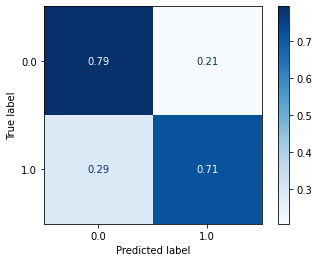

In [59]:
modeler(df2, 'pptu_person', X_word_vec)

Number of positive:  119  Number of negative:  538
Accuracy scores:  [0.793939393939394, 0.7636363636363637, 0.7696969696969697, 0.8121212121212121, 0.8424242424242424]
Mean accuracy:  0.7963636363636363


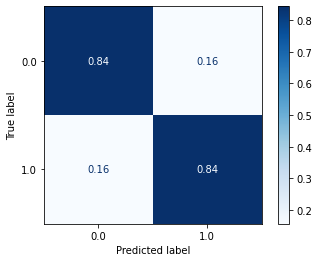

In [60]:
modeler(df2, 'pptu_person', X_all_nodes)

Number of positive:  77  Number of negative:  580
Accuracy scores:  [0.9333333333333333, 0.9212121212121213, 0.8787878787878788, 0.9333333333333333, 0.9333333333333333]
Mean accuracy:  0.9200000000000002


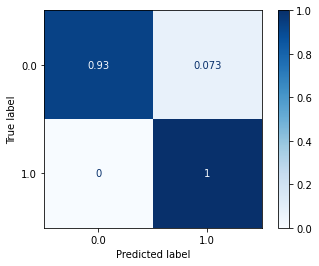

In [61]:
modeler(df2, 'pptu_place', X_word_vec)

Number of positive:  77  Number of negative:  580
Accuracy scores:  [0.9393939393939394, 0.896969696969697, 0.9272727272727272, 0.9333333333333333, 0.9090909090909091]
Mean accuracy:  0.9212121212121213


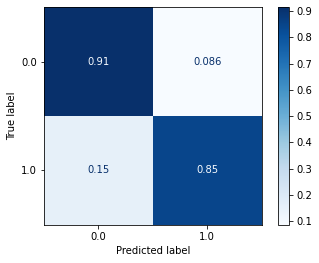

In [62]:
modeler(df2, 'pptu_place', X_all_nodes)

Number of positive:  539  Number of negative:  118
Accuracy scores:  [0.9090909090909091, 0.9030303030303031, 0.9151515151515152, 0.8909090909090909, 0.896969696969697]
Mean accuracy:  0.9030303030303031


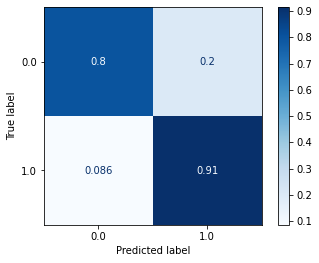

In [63]:
modeler(df2, 'pptu_thing', X_word_vec)

Number of positive:  539  Number of negative:  118
Accuracy scores:  [0.8909090909090909, 0.9212121212121213, 0.9151515151515152, 0.9090909090909091, 0.896969696969697]
Mean accuracy:  0.9066666666666666


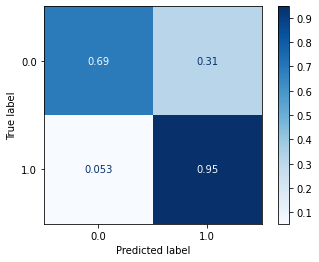

In [64]:
modeler(df, 'pptu_thing', X_all_nodes)

## What just happened???

If you recall, `spacy` generated us 300-dimensional word embeddings for each node.  That size vector is appropriate given the size of the vocabulary for our Google Knowledge Graph-provided descriptions.  But we have also run the accuracy of the graph embeddings, _which are only 10-dimensional vectors_.  That is roughly appropriate because there are so few nodes in the graph and we should not have a higher dimension than the number of nodes.  

**But notice that even with only 10 dimensions we have very comparable accuracy!!!**

That is pretty cool. :)

## Next steps

There are so many things that you can try from here! Some of the things I might consider would be:

- Take time to tune the hyperparameters. This can be done for:
    - The spacy word embeddings
    - The graph embeddings
    - The ML model
- Trying more sophisticated embedding approaches, such as GraphSAGE that takes into account the node properties.
- Explore different embeddings. Here we used the spacy word vectors to create embeddings for the nodes, but there are many, many more ways to create vectors that could be used for training the ML models! Get creative!
- Work the class imbalance problem.  This graph is quite small in reality. Work on growing the graph by adding more layers to it via either Wikipedia or the Google Knowledge Graph. As the graph gets larger, we might expect that the graph embeddings approaches will start to really shine beyond the word embeddings.

